In [2]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys

import time
from stacked_model import *

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

torch.Size([2, 2048, 2048])


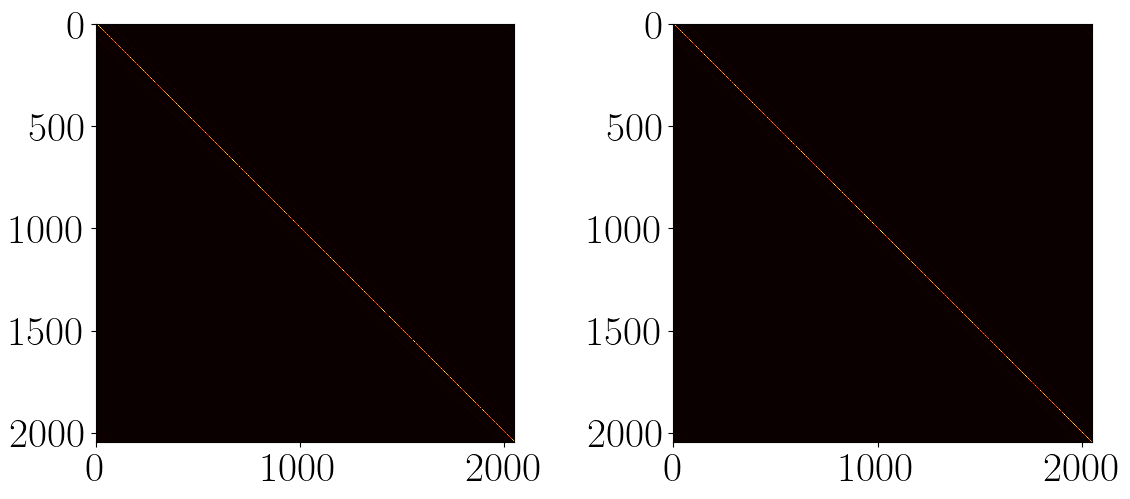

In [4]:
class njl_model:
    def __init__(self,V,l,m,Nf,batch_size=1,device="cpu",dtype=tr.float32): 
        self.V = tuple(V) # lattice size
        self.L = V[0]  # assuming square lattice
        self.kappa = 1/(2*(m + 4))  # Wilson parameter?
        self.Vol = np.prod(V)
        self.Nd = len(V)
        self.Nf = Nf  # number of fermion flavors
        self.lam = l # the coupling
        self.mass  = m
        self.Bs=batch_size
        self.device=device
        self.dtype=dtype

    def gamma_matrices(self):
        gamma0 = tr.tensor([[0., 1.], [1., 0.]])         # sigma_x
        gamma1 = tr.tensor([[0., -1j], [1j, 0.]])        # sigma_y
        return [gamma0.to(tr.cdouble), gamma1.to(tr.cdouble)]

    def site_index(self, x, y, L):
        return (x % L) + L * (y % L)

    def hotStart(self):
        """
        Generate a hot start configuration for the sigma field
        Output: sigma of size (L x L), values in {-1, 1}
        """
        L = self.L
        sigma=tr.normal(0.0,1.0, [self.Bs,self.V[0],self.V[1]], dtype=self.dtype,device=self.device)
        return sigma
    
    def refreshP(self):
        """
            momentum for hamiltonian dynamics
        """
        P = tr.normal(0.0,1.0,[self.Bs,self.V[0],self.V[1]],dtype=self.dtype,device=self.device)
        return P

    def evolveQ(self,dt,P,Q):
        """leapfrog update of field"""
        return Q + dt*P
    
    def kinetic(self,P):
        return tr.einsum('bxy,bxy->b',P,P)/2.0

    def coldStart(self):
        """
        Generate a cold start configuration for the sigma field
        Output: sigma of size (L x L), values in {-1, 1}
        """
        L = self.L
        sigma=tr.ones([self.Bs,self.V[0],self.V[1]], dtype=self.dtype,device=self.device)
        return sigma
    

    def build_DW_wilson(self, sigma):
        """
        Build the 2D Wilson Dirac operator D_W(x,y) for a batch of sigma fields.
        CHANGE: still with for loops, this is inefficient. Check flavor structure and sigma field symmetry
        sigma shape: (Bs, L, L)
        Output: D shape: (Bs, 2L^2, 2L^2), complex dtype.
        """
        L = self.L
        Bs = self.Bs
        kappa = self.kappa
        V = L * L
        dim = 2 * V

        D = tr.zeros((Bs, dim, dim), dtype=tr.cdouble, device=self.device)
        gamma = self.gamma_matrices()
        eye2 = tr.eye(2, dtype=tr.cdouble, device=self.device)

        for x in range(L):
            for y in range(L):
                i = self.site_index(x, y, L)

                # Diagonal: (1 + 2kappa * sigma[b,x,y])
                diag_val = (1.0 + 2.0 * kappa * sigma[:, x, y]).to(tr.cdouble)  # shape: (Bs,)

                for a in range(2):
                    idx = 2 * i + a
                    D[:, idx, idx] = diag_val  # broadcast to batch

                # Off-diagonal: hopping terms
                for mu in range(2):
                    dx, dy = (1, 0) if mu == 0 else (0, 1)
                    gamma_mu = gamma[mu].to(self.device)

                    j_plus = self.site_index(x + dx, y + dy, L)
                    j_minus = self.site_index(x - dx, y - dy, L)

                    hop_plus = (eye2 - gamma_mu) * (-kappa * 0.5)  # shape (2, 2)
                    hop_minus = (eye2 + gamma_mu) * (-kappa * 0.5)

                    for a in range(2):
                        for b in range(2):
                            idx_from = 2 * i + a
                            idx_p = 2 * j_plus + b
                            idx_m = 2 * j_minus + b

                            D[:, idx_from, idx_p] += hop_plus[a, b]
                            D[:, idx_from, idx_m] += hop_minus[a, b]

        return D
        
    def action(self, sigma):

        sig2=sigma*sigma
        A = tr.sum((0.5*self.mass)*sig2,dim=(1,2))
        return A
L = 32
njl = njl_model(V=(L,L), l=0.2, m=0.1,Nf=2,batch_size=2)
sig=njl.hotStart()
D_W = njl.build_DW_wilson(sig)

# Verifica dimensiones
print(D_W.shape)  # torch.Size([32, 32]) para L=4
#print imshow
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[1].imshow(D_W[1].abs().numpy(), cmap='hot', interpolation='nearest')
ax[0].imshow(D_W[0].abs().numpy(), cmap='hot', interpolation='nearest')



torch.Size([2048]) torch.Size([2048])


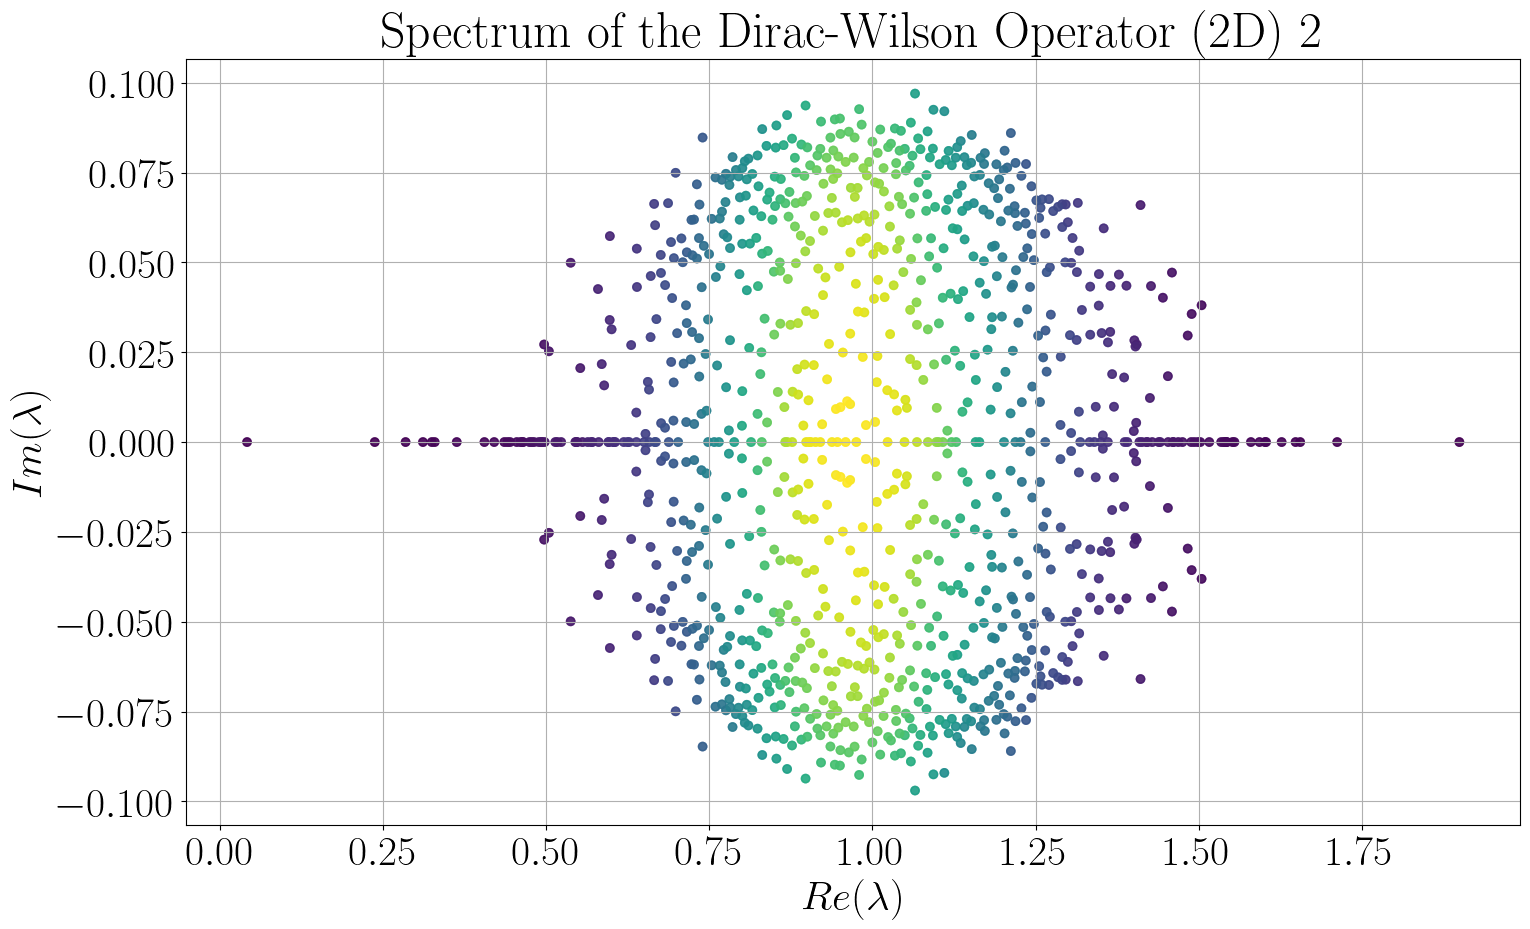

In [5]:
eigvals = tr.linalg.eigvals(D_W[0])
print(eigvals.real.shape, eigvals.imag.shape)
eigvals_np = eigvals.detach().cpu().numpy()

plt.figure(figsize=(16, 10))
#points random colors
colors = plt.cm.viridis(np.linspace(0, 1, eigvals_np.shape[0]))
#random colors
#colors = np.random.rand(eigvals_np.shape[0], 3)
plt.scatter(eigvals_np.real, eigvals_np.imag,alpha=0.7, marker='o',color=colors)
plt.xlabel(r"$Re(\lambda)$")
plt.ylabel(r"$Im(\lambda)$")
eigen_number = D_W.shape[0]
plt.title(f"Spectrum of the Dirac-Wilson Operator (2D) {eigen_number}")
#plt.xlim(0.4, 1.6)

plt.grid(True)
#plt.gca().set_aspect('equal')
plt.show()